## Transfer learning and fine-tuning
* A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.
* 직관적으로 생각해 볼 때, 이미지 분류를 위한 전이 학습은 모델이 충분히 크고 일반적인 데이터 집합에서 훈련된다면, 이 모델은 사실상 visual world의 일반적인 모델로서 기능을 할 수 있을 것이라고 생각할 수 있다. 이것이 가능하면, 대규모 데이터셋에서 대규모 모델을 훈련시켜 처음부터 시작할 필요 없이 이러한 학습된 feature map을 다양한 문제에 활용할 수 있다.
* Pre-trained model 을 활용하는 방법은 크게 Feature Extraction 과 Fine Tuning 두가지 방법으로 구분할 수 있다.
    * Feature Extraction:  새 샘플에서 의미 있는 feature를 추출하기 위해 이전 네트워크에서 학습한 표현(representations)을 사용한다. 사전 훈련된 모델 위에 처음부터 훈련할 새 분류기를 추가하기만 하면 이전에 데이터셋으로 학습한 특징 맵의 용도를 재사용할 수 있다. 전체 모델을 재훈련시킬 필요는 없다. 기본 컨볼루션 네트워크에는 그림 분류에 일반적으로 유용한 feature들이 이미 포함되어 있다. 그러나 사전 훈련된 모델의 최종 분류 부분은 기존의 분류 작업에 따라 다르며 이후에 모델이 훈련된 클래스 집합에 따라 다르다.
    * Fine Tuning : 고정된 기본 모델의 일부 최상위 층을 고정 해제하고 새로 추가 된 분류기 층과 기본 모델의 마지막 층을 함께 훈련시키는 방법이다. 이를 통해 기본 모델에서 고차원 특징 표현을 "미세 조정"하여 특정 작업에 보다 관련성을 높이는 학습이 가능해진다.

* You will follow the general machine learning workflow.

    1) Examine and understand the data

    2) Build an input pipeline, in this case using Keras ImageDataGenerator

    3) Compose the model

    Load in the pretrained base model (and pretrained weights)

    Stack the classification layers on top

    4) Train the model

    5) Evaluate model

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    # %tensorflow_version은 Colab에서만 지원됩니다.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
keras = tf.keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()


### Data preprocessing
#### Data download
* 고양이와 개의 데이터셋을 가져오기 위해 Tensorflow 데이터셋을 활용

* tfds패키지는 미리 정의 된 데이터를 가져오는 가장 쉬운 방법이다. 본인 만의 데이터가 있고 Tensorflow에서 이 패키지를 이용해 데이터를 가져오려는 경우 다음 URL 확인 
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(raw_train)
print(raw_validation)
print(raw_test)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompletePAO13M/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


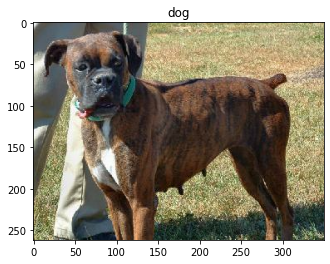

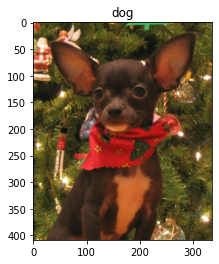

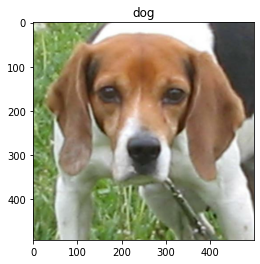

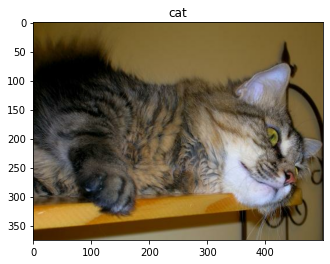

In [ ]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(4):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

### Configure the dataset for performance
* tf.image 모듈을 사용하여 이미지 데이터의 값을 조정
* 이미지를 고정 된 입력 크기로 고정하고 입력 채널의 크기를 [-1,1] 범위로 scaling


In [ ]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

### Create the base model from the pre-trained convnets
* Google에서 개발한 MobileNet V2 모델로부터 기본 모델을 생성.This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

* 먼저 기능 추출에 사용할 MobileNet V2 층을 선택해야 한다. 가장 최근의 분류 층 (last classification layer) ("맨 위층", 대부분의 머신 러닝 모델 다이어그램은 아래에서 위로 이동하므로)은 유용하지 않기 떄문에 flatten 연산을 하기 전에 맨 아래 층을 활용한다. 이 층을 "Bottleneck layer" 라 한다. 병목 층은 맨 위층보다 일반성을 가지는 feature를 포함한다.

* 먼저 ImageNet으로 훈련된 가중치가 저장된 MobileNet V2 모델을 인스턴스화 해야 한다. **include_top = False** 로 지정하면 맨 위에 분류 층이 포함되지 않은 네트워크를 로드하므로 특징 추출에 알맞다.

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction
* In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
* It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Important note about BatchNormalization layers
* Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

* When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

* When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

### Add a classification head
* To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a **tf.keras.layers.GlobalAveragePooling2D** layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


* Apply a **tf.keras.layers.Dense** layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 3s 58ms/step - loss: 0.7522 - accuracy: 0.5031
initial loss: 0.75
initial accuracy: 0.50


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 53s 83ms/step - loss: 0.2072 - accuracy: 0.9066 - val_loss: 0.0870 - val_accuracy: 0.9686
Epoch 2/10
582/582 [==============================] - 49s 82ms/step - loss: 0.0728 - accuracy: 0.9745 - val_loss: 0.0634 - val_accuracy: 0.9789
Epoch 3/10
582/582 [==============================] - 49s 82ms/step - loss: 0.0582 - accuracy: 0.9785 - val_loss: 0.0558 - val_accuracy: 0.9819
Epoch 4/10
582/582 [==============================] - 49s 81ms/step - loss: 0.0521 - accuracy: 0.9801 - val_loss: 0.0522 - val_accuracy: 0.9824
Epoch 5/10
582/582 [==============================] - 48s 80ms/step - loss: 0.0487 - accuracy: 0.9818 - val_loss: 0.0502 - val_accuracy: 0.9828
Epoch 6/10
582/582 [==============================] - 49s 81ms/step - loss: 0.0462 - accuracy: 0.9831 - val_loss: 0.0487 - val_accuracy: 0.9837
Epoch 7/10
582/582 [==============================] - 49s 81ms/step - loss: 0.0445 - accuracy: 0.9840 - val_loss: 0.0478 - val_accuracy:

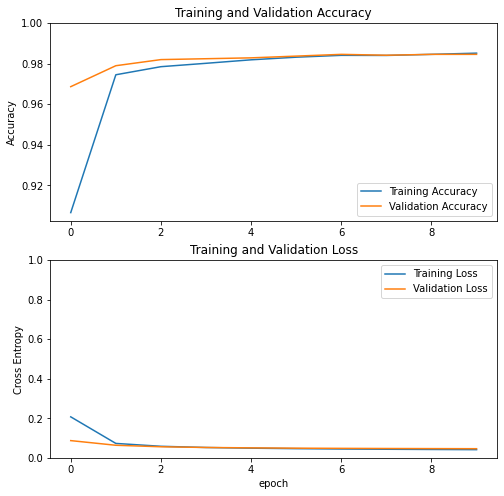

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning
* Feature extraction 에서는 MobileNet V2 기본 모델을 기반으로 몇 개의 층 만 학습했으나 사전에 훈련된 네트워크의 가중치는 훈련 중에 업데이트 되지 않았다.

* 성능을 더욱 향상시키는 한 가지 방법은 추가한 분류기의 훈련과 함께 사전 훈련된 모델의 최상위 레이어 가중치를 훈련("미세 조정")하는 것이다. 훈련을 통해 가중치는 일반적인 특징 맵에서 개별 데이터셋과 관련된 특징으로 조정된다.

* **Note**: 사전 훈련된 모델을 훈련 불가능으로 설정하여 최상위 분류기를 훈련한 후에만 ​​시도해야 한다. 사전 훈련된 모델 위에 무작위로 초기화된 분류기를 추가하고 모든 레이어를 공동으로 훈련하려고하면 (분류기가 가중치를 임의 설정하기 때문에) 그래디언트 업데이트의 크기가 너무 커지고 사전 훈련된 모델은 배운 것을 잊어버리게 된다.

### Un-freeze the top layers of the model
* base_model 훈련 고정을 해제하고 맨 아래 층을 훈련 할 수 없도록 설정한다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 한다.

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 6
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/16
582/582 [==============================] - 57s 86ms/step - loss: 0.1264 - accuracy: 0.9543 - val_loss: 0.0734 - val_accuracy: 0.9789
Epoch 11/16
582/582 [==============================] - 51s 86ms/step - loss: 0.0681 - accuracy: 0.9740 - val_loss: 0.0575 - val_accuracy: 0.9811
Epoch 12/16
582/582 [==============================] - 52s 86ms/step - loss: 0.0544 - accuracy: 0.9787 - val_loss: 0.0496 - val_accuracy: 0.9837
Epoch 13/16
582/582 [==============================] - 51s 85ms/step - loss: 0.0386 - accuracy: 0.9854 - val_loss: 0.0472 - val_accuracy: 0.9819
Epoch 14/16
582/582 [==============================] - 52s 87ms/step - loss: 0.0312 - accuracy: 0.9877 - val_loss: 0.0470 - val_accuracy: 0.9828
Epoch 15/16
582/582 [==============================] - 52s 87ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.0483 - val_accuracy: 0.9837
Epoch 16/16
582/582 [==============================] - 52s 87ms/step - loss: 0.0197 - accuracy: 0.9930 - val_loss: 0.0501 - val_ac

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

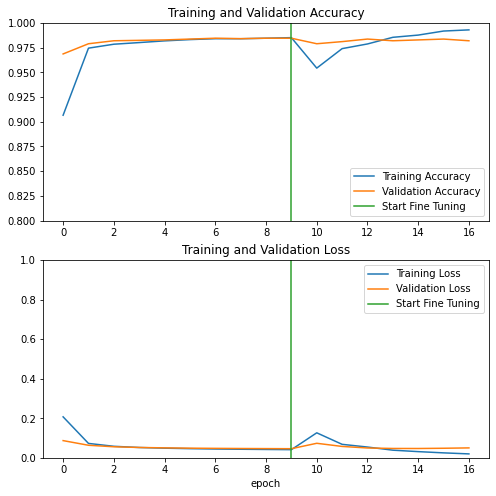

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

73/73 [==============================] - 5s 63ms/step - loss: 0.0501 - accuracy: 0.9798
Test accuracy : 0.9797936081886292


Predictions:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
Labels:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]


<Figure size 720x720 with 0 Axes>

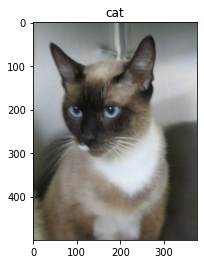

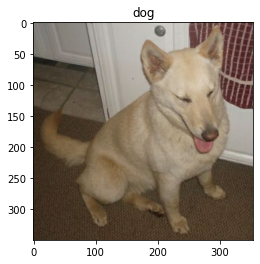

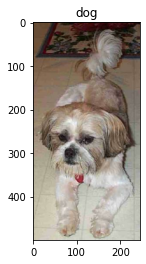

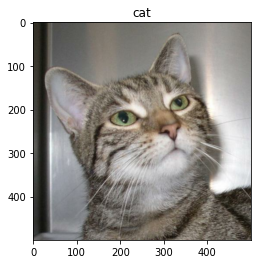

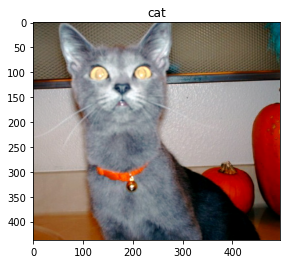

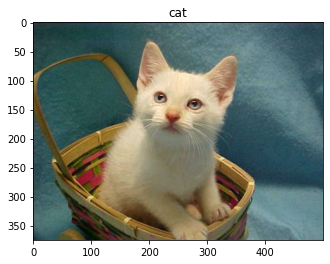

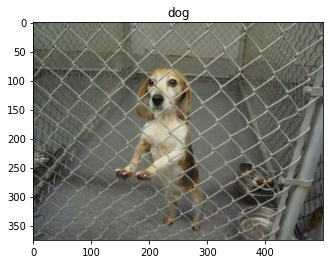

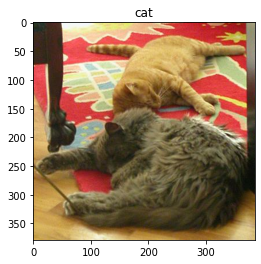

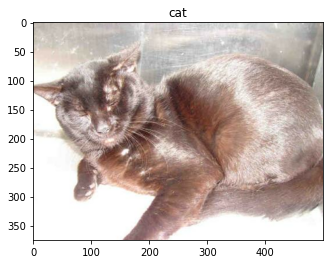

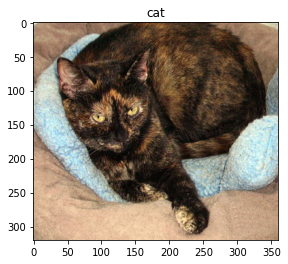

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for image, label in raw_test.take(10):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

### Summary
* Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

----

## Transfer learning with TensorFlow Hub

* TensorFlow Hub is a repository of pre-trained TensorFlow models.

* This tutorial demonstrates how to:
    
    * Use models from TensorFlow Hub with tf.keras
    
    * Use an image classification model from TensorFlow Hub
    
    * Do simple transfer learning to fine-tune a model for your own image classes

In [ ]:
import matplotlib.pylab as plt
import tensorflow as tf

!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub
from tensorflow.keras import layers

     |████████████████████████████████| 112kB 7.5MB/s 


* Use hub.KerasLayer to load a MobileNetV2 model from TensorFlow Hub. Any compatible image classifier model from tfhub.dev will work here. https://tfhub.dev/s?module-type=image-classification&q=tf2 

In [ ]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 0us/step


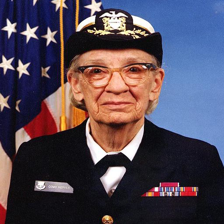

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


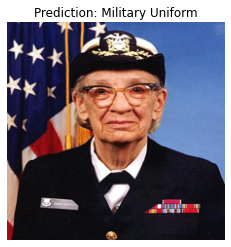

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### Simple transfer learning

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


* 모델에 이 데이터를 가장 간단하게 로딩 하는 방법은 tf.keras.preprocessing.image.image.ImageDataGenerator를 사용하는 것이고, 모든 텐서플로 허브의 이미지 모듈들은 0과 1사이의 상수들의 입력을 필요로 한다. 이를 만족 시키기 위해 ImageDataGenerator의 rescale 을 사용한다.

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'American chameleon', 'spider web', 'bee', 'velvet',
       'daisy', 'ant', 'sulphur butterfly', 'daisy', 'maze',
       'hummingbird', 'daisy', 'bonnet', 'daisy', 'fountain', 'maze',
       'matchstick', 'Persian cat', 'artichoke', 'picket fence', 'pot',
       'daisy', 'picket fence', 'ant', 'bee', 'daisy', 'umbrella',
       'rapeseed', 'pot', 'pot', 'daisy', 'picket fence'], dtype='<U30')

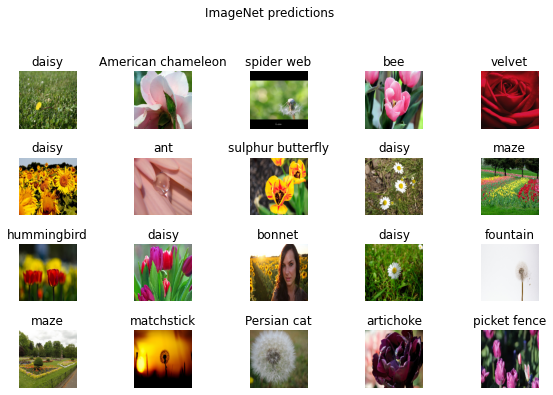

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

### Download headless model
* 텐서플로 허브는 맨 위 분류층이 없는 모델을 제공한다. 이는 전이 학습을 쉽게 할 수 있게 한다. https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 5])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 17s 120ms/step - loss: 0.6112 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 14s 118ms/step - loss: 0.3605 - acc: 0.8438


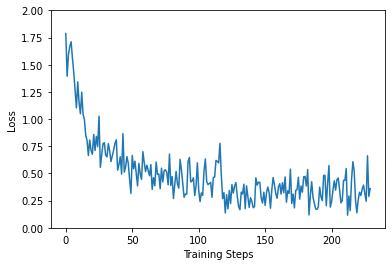

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

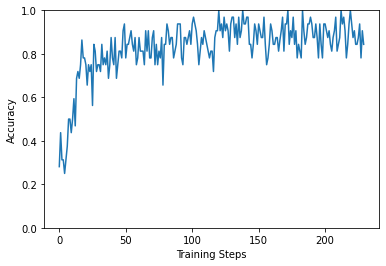

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [ ]:
label_id = np.argmax(label_batch, axis=-1)

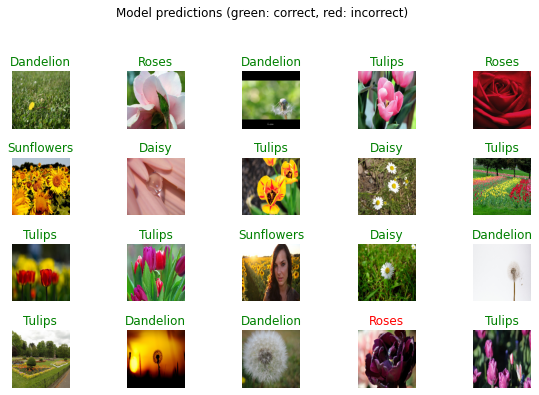

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### Export your model

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1622549395/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1622549395/assets


'/tmp/saved_models/1622549395'

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

0.0